In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install seaborn

# Imports

In [142]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib_inline.backend_inline
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Getting data

In [143]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')

train_set.drop('id',axis='columns', inplace=True)
corr = train_set.corr(method = 'pearson')

ids = test_set['id'].to_numpy()

Y = train_set.pop('FloodProbability').to_numpy().reshape(-1,1)
X = train_set.to_numpy()

X_names = train_set.columns.to_list()
print(X.shape, Y.shape)
print(X_names)

(1117957, 20) (1117957, 1)
['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']


In [144]:
x_sum = np.sum(X,axis=1).reshape(-1,1)

# Visualizing data

<Axes: >

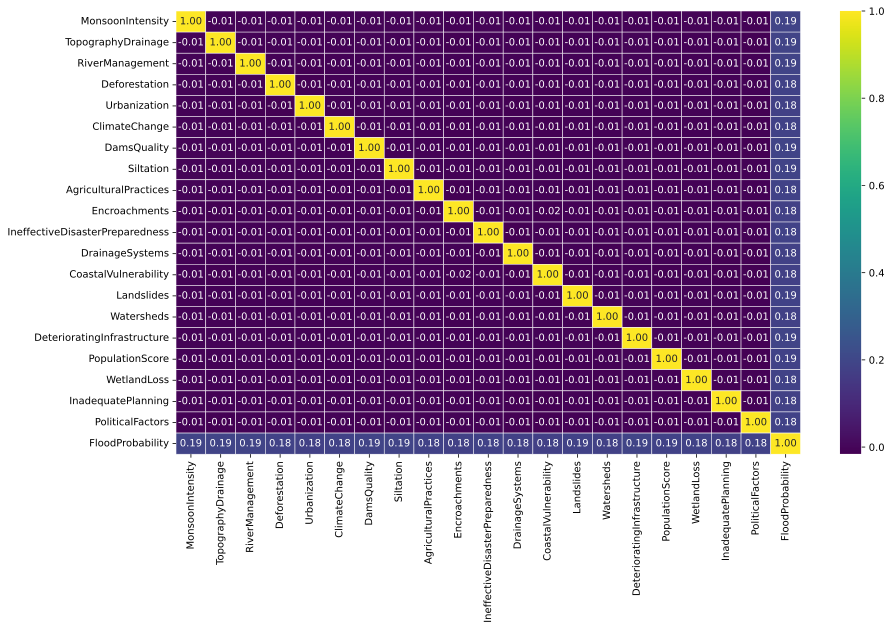

In [145]:
plt.figure(figsize=[14,8])
sns.heatmap(corr,fmt=".2f", linewidth=.5,cmap='viridis',annot=True)

# Feature Engineering

Nonlinear correlations

TopographyDrainage x Urbanization has 0.2693319461788647 correlation to Y
TopographyDrainage x AgriculturalPractices has 0.26544067612862793 correlation to Y
TopographyDrainage x DeterioratingInfrastructure has 0.2669631141863102 correlation to Y
TopographyDrainage x PoliticalFactors has 0.2659362516885665 correlation to Y
RiverManagement x Urbanization has 0.2713590115218027 correlation to Y
RiverManagement x Siltation has 0.2713494711604444 correlation to Y
RiverManagement x DrainageSystems has 0.2658140126953737 correlation to Y
RiverManagement x DeterioratingInfrastructure has 0.2687941456031121 correlation to Y
RiverManagement x WetlandLoss has 0.2709408450587938 correlation to Y
RiverManagement x PoliticalFactors has 0.2693834724328031 correlation to Y
Urbanization x ClimateChange has 0.2657674708062914 correlation to Y
Urbanization x DamsQuality has 0.2737751534940923 correlation to Y
Urbanization x Siltation has 0.2675883933281682 correlation to Y
Urbanization x AgriculturalPra

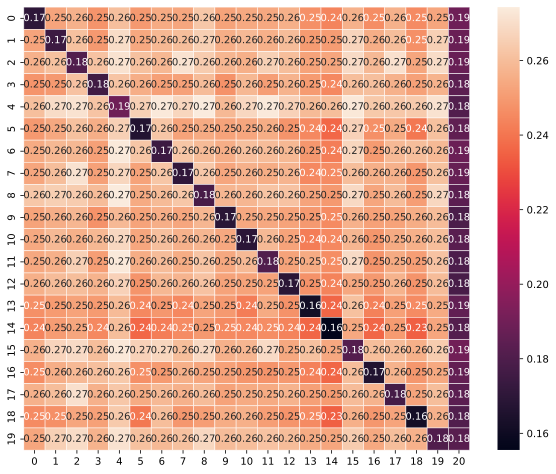

In [146]:
n_feat = X.shape[1]
feat_coef = corr.to_numpy()[:-1,-1].reshape(-1,1)
mult_coefs = np.zeros((n_feat,n_feat))
eval = []
perm = []
''' 
for i in range(n_feat):
    # getting raw features coef
    feat_coef[i,0] = np.corrcoef(X[::100,i],Y[::100],rowvar=False)[0,1]
'''
for i in range(n_feat):
    for j in range(n_feat):
        x_test = X[:,i]*X[:,j]
        coef = np.corrcoef(x_test[::100],Y[::100],rowvar=False)[0,1]
        mult_coefs[i,j] = coef
        if (coef > 0.265) and ((i,j) not in eval):
            print(f"{X_names[i]} x {X_names[j]} has {coef} correlation to Y") 
            perm.append((i,j))
            eval.append((j,i))
            eval.append((i,j))
            X_names.append(f"{X_names[i]} x {X_names[j]}")
            X = np.hstack((X,x_test.reshape(-1,1)))
            

test = np.hstack((mult_coefs,feat_coef))
print(perm)
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(test,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [147]:
X = np.hstack((X,x_sum))
X_names.append("SumAll")
print(X.shape)
print(X_names)

(1117957, 45)
['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors', 'TopographyDrainage x Urbanization', 'TopographyDrainage x AgriculturalPractices', 'TopographyDrainage x DeterioratingInfrastructure', 'TopographyDrainage x PoliticalFactors', 'RiverManagement x Urbanization', 'RiverManagement x Siltation', 'RiverManagement x DrainageSystems', 'RiverManagement x DeterioratingInfrastructure', 'RiverManagement x WetlandLoss', 'RiverManagement x PoliticalFactors', 'Urbanization x ClimateChange', 'Urbanization x DamsQuality', 'Urbanization x Siltation', 'Urbanization x AgriculturalPractices', 'Urbanization x IneffectiveDisasterPreparedness', 'Urbanization

# Spliting data


In [148]:
x_train, x_cv, y_train, y_cv = train_test_split(X,Y,test_size=0.2)
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_cv = torch.Tensor(x_cv)
y_cv = torch.Tensor(y_cv)

print(x_train.shape,y_train.shape)
print(x_cv.shape,y_cv.shape)


torch.Size([894365, 45]) torch.Size([894365, 1])
torch.Size([223592, 45]) torch.Size([223592, 1])


# Normalizing data

In [149]:
scaler = StandardScaler().fit(x_train)
x_train = torch.Tensor(scaler.transform(x_train))
x_cv = torch.Tensor(scaler.transform(x_cv))
print(x_train[:5,:])

tensor([[ 0.5240, -1.3986,  0.9878, -0.4599, -0.4521, -1.4256, -0.4590, -0.9323,
          0.5103,  0.0242,  0.0272,  2.9209,  0.0218,  0.0332,  0.0343,  0.0351,
         -0.9296,  0.5070, -0.4514,  0.0293, -1.0834, -0.8197, -0.9484, -0.9494,
          0.2383, -0.2249,  3.5074,  0.7083,  1.1683,  0.7046, -1.0931, -0.5610,
         -0.8225, -0.0258, -0.2919,  1.3079, -0.2939, -0.2876, -0.2890, -0.9578,
         -0.2917,  0.3802,  0.3752,  2.0495, -0.2152],
        [-0.4483,  1.4677, -1.4258, -0.9470, -0.9323, -0.9395, -0.9391,  1.9723,
         -1.4228, -0.4558, -2.3794, -0.9398,  0.9791, -0.4479, -1.8871,  0.0351,
         -0.4476, -1.4254,  0.0292,  0.9863, -0.0202, -0.5535,  1.0483,  2.1079,
         -1.2286, -0.4256, -1.2321, -0.9598, -1.3658, -0.6934, -1.0261, -1.0263,
          0.1807, -1.2264, -1.6276, -1.0268, -0.2274, -0.6216, -0.2226, -0.6225,
         -0.6249, -0.9592, -0.6910, -0.6241, -2.3822],
        [ 0.0378,  0.0345,  0.5051,  1.0014, -1.4124,  2.4626, -0.4590,  0.0359,

# Model construction

In [90]:
class floodProb(nn.Module):
    def __init__(self,nUnits,nLayers):
        '''Populate with the layers of the model'''
        super(floodProb,self).__init__()

        self.nLayers = nLayers
        
        self.layers = nn.ModuleDict({name:layer for name,layer in zip([f'hidden{i}' for i in range(nLayers)],[nn.Linear(nUnits,nUnits) for j in range(nLayers)])})
        
        self.layers['input'] = nn.Linear(in_features=20,out_features=nUnits)
        self.layers['output'] = nn.Linear(nUnits,1)


    def forward(self,x):
        '''Operations that are taking place in the layers'''

        # input
        x = F.relu(self.layers['input'](x))
        for l in range(self.nLayers):
            x = F.relu(self.layers[f'hidden{l}'](x))
        # output
        x = self.layers['output'](x)

        return x

In [127]:
class floodProbc(nn.Module):
    def __init__(self):
        super(floodProbc, self).__init__()
        self.fc1 = nn.Linear(45,39)
        self.fc2 = nn.Linear(39,26)
        self.fc3 = nn.Linear(26,13)
        self.fc4 = nn.Linear(13,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

In [150]:
def train(model, lossfun, optimizer, inputs, targets, epochs=100):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    inputs, targets = inputs.to(device), targets.to(device)
    
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfun(outputs, targets)
        loss.backward()
        optimizer.step()
        losses[epoch] = loss.item()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()} - R2: {r2_score(y_true=targets.cpu(),y_pred=outputs.cpu().detach())}')
    return losses

In [129]:
# test
epochs = 10000
device = "cuda" if torch.cuda.is_available() else "cpu"

model = floodProbc()
print(nn.L1Loss()(model(x_train),y_train))
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
model.train()
losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs)
print(np.min(losses))
model.eval()
with torch.no_grad():
    outputs = model(x_cv.to(device))
    loss_cv = nn.MSELoss()(outputs, y_cv.to(device))

print(loss_cv)


tensor(0.0418, grad_fn=<MeanBackward0>)
Epoch 0/10000 - Loss: 0.00273467181250453 - R2: -0.049907792732189815
Epoch 100/10000 - Loss: 0.000386815401725471 - R2: 0.8514920434835562
Epoch 200/10000 - Loss: 0.0003694189654197544 - R2: 0.8581709707747579
Epoch 300/10000 - Loss: 0.0003639560891315341 - R2: 0.8602683015066743
Epoch 400/10000 - Loss: 0.000360495294444263 - R2: 0.8615969864643167
Epoch 500/10000 - Loss: 0.00035934525658376515 - R2: 0.8620385236161436
Epoch 600/10000 - Loss: 0.00035901370574720204 - R2: 0.8621657959507525
Epoch 700/10000 - Loss: 0.0003582968201953918 - R2: 0.8624410403473732
Epoch 800/10000 - Loss: 0.0003581486234907061 - R2: 0.8624979340692319
Epoch 900/10000 - Loss: 0.0003580048505682498 - R2: 0.8625531154016987
Epoch 1000/10000 - Loss: 0.00035749489325098693 - R2: 0.8627489083670299
Epoch 1100/10000 - Loss: 0.0003594639420043677 - R2: 0.8619929444084918
Epoch 1200/10000 - Loss: 0.00035806791856884956 - R2: 0.8625289106422268
Epoch 1300/10000 - Loss: 0.000356

In [151]:
r2_score(y_true=outputs.cpu(),y_pred=y_cv.cpu())

-1.1447594082703398

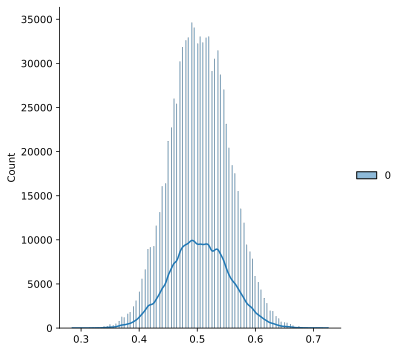

In [152]:
sns.displot(y_train,kde=True)

In [132]:
test_X = test_set.to_numpy()[:,1:]

test_X_sum = np.sum(test_X,axis=1).reshape(-1,1)
new_col = np.zeros((test_X.shape[0],len(perm)))

for idx,(i,j) in enumerate(perm):
    new_col[:,idx] = (test_X[:,i]*test_X[:,j])

test_X = np.hstack((test_X,new_col,test_X_sum))

print(test_X.shape)


(745305, 45)


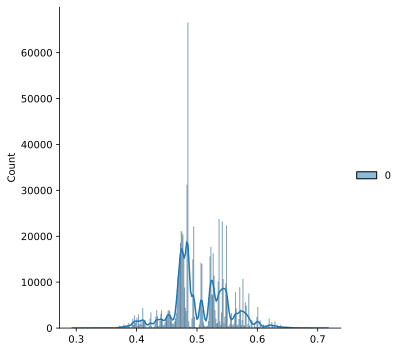

In [133]:
x_test = torch.Tensor(scaler.transform(test_X)).to(device)
y_pred_test = model(x_test).cpu().detach().numpy()

sns.displot(y_pred_test, kde=True)

In [134]:

with open('./data/submission3.csv','w') as sub:
    sub.write("id,FloodProbability\n")
    for id,pred in zip(ids,y_pred_test):
        sub.write(f"{id},{pred[0]}\n")


In [160]:
class floodProbDE(nn.Module):
    def __init__(self):
        super(floodProbDE, self).__init__()
        self.fc1 = nn.Linear(45,40)
        self.fce = nn.Linear(40,35)
        self.fc2 = nn.Linear(35,30)
        self.fc3 = nn.Linear(30,25)
        self.fc4 = nn.Linear(25,15)
        self.fc5 = nn.Linear(15,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fce(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

In [161]:
# test
epochs = 10000
device = "cuda" if torch.cuda.is_available() else "cpu"

model2 = floodProbDE()
print(nn.L1Loss()(model2(x_train),y_train))
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.008)
model2.train()
losses2 = train(model2, nn.MSELoss(), optimizer2, x_train, y_train,epochs=epochs)
print(np.min(losses2))
model2.eval()
with torch.no_grad():
    outputs = model2(x_cv.to(device))
    loss_cv = nn.MSELoss()(outputs, y_cv.to(device))

print(loss_cv)

r2_score(y_true=outputs.cpu(),y_pred=y_cv.cpu())


tensor(0.0559, grad_fn=<MeanBackward0>)
Epoch 0/10000 - Loss: 0.004643432796001434 - R2: -0.7847257217403387
Epoch 100/10000 - Loss: 0.0003917741123586893 - R2: 0.8494197504423422
Epoch 200/10000 - Loss: 0.0003840372373815626 - R2: 0.8523934512230509
Epoch 300/10000 - Loss: 0.0003808327601291239 - R2: 0.8536251149003434
Epoch 400/10000 - Loss: 0.0003788750618696213 - R2: 0.8543775520432213
Epoch 500/10000 - Loss: 0.0003712127509061247 - R2: 0.8573225968544833
Epoch 600/10000 - Loss: 0.00036046915920451283 - R2: 0.8614519581779065
Epoch 700/10000 - Loss: 0.00036109413485974073 - R2: 0.861211731649169
Epoch 800/10000 - Loss: 0.0003584272344596684 - R2: 0.8622367775935378
Epoch 900/10000 - Loss: 0.00035833861329592764 - R2: 0.8622708382557461
Epoch 1000/10000 - Loss: 0.0003589071857277304 - R2: 0.8620523020010888
Epoch 1100/10000 - Loss: 0.00035734008997678757 - R2: 0.862654611954831
Epoch 1200/10000 - Loss: 0.00035688720527105033 - R2: 0.862828696302556
Epoch 1300/10000 - Loss: 0.0003577

0.8422814151777976

In [164]:
with open('./data/submission5.csv','w') as sub:
    sub.write("id,FloodProbability\n")
    for id,pred in zip(ids,y_pred_test):
        sub.write(f"{id},{pred[0]}\n")

In [162]:
test_X = test_set.to_numpy()[:,1:]

test_X_sum = np.sum(test_X,axis=1).reshape(-1,1)
new_col = np.zeros((test_X.shape[0],len(perm)))

for idx,(i,j) in enumerate(perm):
    new_col[:,idx] = (test_X[:,i]*test_X[:,j])


test_X = np.hstack((test_X,new_col,test_X_sum))

print(test_X.shape)

(745305, 45)


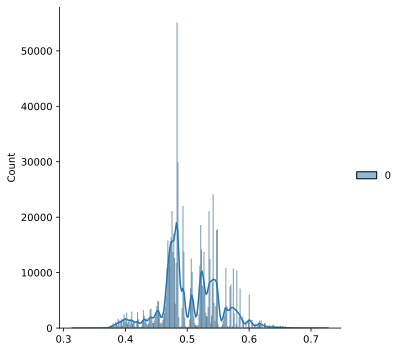

In [163]:
x_test = torch.Tensor(scaler.transform(test_X)).to(device)
y_pred_test = model2(x_test).cpu().detach().numpy()

sns.displot(y_pred_test, kde=True)